# Surprises in a classic boundary-layer problem
## Companion notebook: numerics

Author: Leo C. Stein (leo.stein@gmail.com)

Date: 2021 July

This notebook is a companion to the article of the same name \[[arXiv:2107.11624](https://arxiv.org/abs/2107.11624)\].
Please contact the authors for questions about use, attribution, and distribution.

We will need `numpy`, `matplotlib`, and `mpmath`

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', **{'size': 14, 'family': 'serif', 'serif': ['Computer Modern Roman']})
rc('text', usetex=True)

In [2]:
from mpmath import *
import numpy as np

In [3]:
mp.pretty = True
# This is how you control the number of digits in calculations:
mp.dps=30

# First examples with mpmath – finding the bifurcation $\epsilon_c$ and $z_c$

In the function whose root gives $z_c$, there is an integral that depends on the trial value of $z_c$. Generate this integrand:

In [4]:
def give_integrand(zc):
    def integrand(z):
        arg_of_root = 1-(z+log(1-z))/(zc+log(1-zc))
        return 1/((z-1)*sqrt(arg_of_root))
    return integrand

Here's the function $g(z)$ that has a root at the bifurcation value $z_c$. We use `quad` from `mpmath` to integrate.

In [5]:
def g_root(zc):
    return zc + log(1-zc) + quad( give_integrand(zc), [0, zc] )

Do the root-finding!

In [6]:
zc_sol = findroot(g_root, -3.9052637703)
zc_sol

-3.90526377028249049653129176948

Check how well we solved:

In [7]:
g_root(zc_sol)

-9.68765748994122807117801976686e-18

How to convert from $z_c$ to $\epsilon_c$:

In [8]:
def eps_c_of_z_c(zc):
    return -1/(2*(zc+log(1-zc)))

In [9]:
epsc = eps_c_of_z_c(zc_sol)
epsc

0.215986928890290045090795596541

Check what we get if we change the number of decimal places

In [10]:
mp.dps=50
zc_sol = findroot(g_root, -3.9052637703)
print(f'z_c={zc_sol}')
epsc = eps_c_of_z_c(zc_sol)
print(f'eps_c={epsc}')

z_c=-3.9052637702824904965490403615018119794729534779659
eps_c=0.21598692889029004508947722795015610617409536512032


# Solving an IVP with mpamth

Define the first-order ODE system

In [11]:
def make_odesys(eps):
    def odesys(x, state):
        y, z = state

        return [z, y*(z-1)/eps]
    return odesys

Create the abstract solution, that can be evaluated at later times

In [12]:
mp.dps = 30
sol_0p1_p9999 = odefun(make_odesys(0.1), # ODE system
                       0,  # initial time
                       [1, 0.9999]) # Initial conditions

Evaluate at time $t=1$.

In [13]:
sol_0p1_p9999(1)

[-1.01284391452827395473357486138, -10.5257610143041294880858710996]

That was close to solving the BVP! But we need to do better, so let's use `findroot` to drive a shooting method. We will need good initial guesses – so we use our asymptotic results.

# Asymptotic initial slopes

In [14]:
def y_prime_B0_asymp(eps):
    return 1 - 3/(2*eps) + log(16)

def one_minus_y_prime_B1_asymp(eps):
    return exp(-3/(2*eps))*(24/eps-16*log(16))

def one_minus_y_prime_M_asymp(eps):
    return exp(-5/(8*eps))*(9/(2*eps)-4*log(4))

# Solving the BVP with the shooting method

A helper function, to get the target value

In [15]:
def y_at_x_eq_1(eps, y_prime_0):
    sol = odefun(make_odesys(eps), 0, [1, y_prime_0])
    y1, _ = sol(1)
    return y1

Let's plot this function for some epsilon to examine it.  Evaluate on a grid of values spaced linearly in $1-\log(y'(0))$.

In [16]:
%%time
mp.dps=20
eps = 0.1
zmin, zmax = -18, 0.99999

qs = np.linspace(np.log(1-zmin), np.log(1-zmax), num=50)
y_primes = 1. - np.exp(qs)
y_finals = np.array([y_at_x_eq_1(eps, y_prime_0)
                     for y_prime_0 in y_primes])

CPU times: user 8.43 s, sys: 25.7 ms, total: 8.45 s
Wall time: 8.47 s


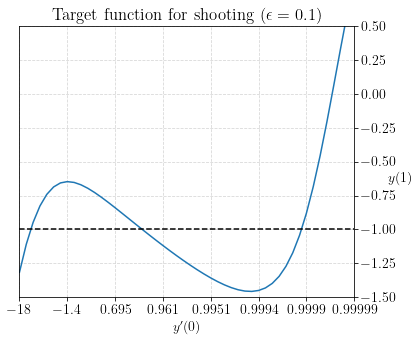

In [17]:
plt.figure(figsize=(6,5))

plt.plot(qs, y_finals)
plt.plot(qs, -np.ones_like(y_primes), 'k--')

nticks = 8

manual_ticks = np.linspace(np.log(1-zmin), np.log(1-zmax), num=nticks)
z_ticks = 1.-np.exp(manual_ticks)
# print_widths = -1-np.floor(np.log10(np.abs(1-z_ticks)))
# print_widths[print_widths < 4] = 4
print_widths = [0, 1, 3, 3, 4, 4, 4, 5]
plt.xticks(ticks=manual_ticks,
           labels=[f'${z: .{int(w)}f}$' for z,w in zip(z_ticks,print_widths)])

ax = plt.gca()

ax.invert_xaxis()
plt.xlabel('$y\'(0)$')
ylab = plt.ylabel('$y(1)$')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ylab.set_rotation(0)
old_y_pos = ylab.get_position()
ylab.set_position((old_y_pos[0], old_y_pos[1] - 0.04))
plt.title(f'Target function for shooting ($\\epsilon={eps}$)')
plt.xlim((qs[0],qs[-1]))
plt.ylim((-1.5, 0.5))
plt.grid(linestyle='dashed', alpha=0.5)

plt.show()

So, we want to use our asymptotics and `findroot` to drive shooting routines. Bracket the roots for the M and B1 cases, so we don't accidentally step across $y'(0)=1$. The 'anderson' method will work.

In [18]:
def y_prime_B0_num(eps):
    return findroot(lambda y_prime_0: 1+y_at_x_eq_1(eps, y_prime_0),
                    y_prime_B0_asymp(eps))

def y_prime_B1_num(eps, verbose=False, verify=False, solver='anderson'):
    delta = one_minus_y_prime_B1_asymp(eps)
    return findroot(lambda y_prime_0: 1+y_at_x_eq_1(eps, y_prime_0),
                    (1-2*delta, 1), solver=solver,
                    verbose=verbose,
                    verify=verify)

def y_prime_M_num(eps, verbose=False, verify=False, solver='anderson'):
    delta = one_minus_y_prime_M_asymp(eps)
    return findroot(lambda y_prime_0: 1+y_at_x_eq_1(eps, y_prime_0),
                    (1-2*delta, 1-delta/2),
                    solver=solver,
                    verbose=verbose,
                    verify=verify)

We can see what the shooting routine is doing internally, by using `verbose=True`:

In [23]:
%%time
mp.dps=15
y_prime_B1_eps_0p1 = y_prime_B1_num(0.1, verbose=False, solver='bisect')

CPU times: user 8.75 s, sys: 67.3 ms, total: 8.82 s
Wall time: 8.89 s


In [24]:
%%time
mp.dps=15
y_prime_B1_eps_0p1 = y_prime_B1_num(0.1, verbose=True, solver='anderson')

using anderson method
x:     0.999942072625309982667
error: 0.000119692591475151211
m: 0.152927108730732623388
x:     0.999943660990907773302
error: 0.000115854749380034665365
m: 0.152927108730732623388
x:     0.999894931686233946064
error: 0.000112678018184453395266
m: 0.152927108730732623388
x:     0.99990248439873014355
error: 0.0000152194088367989187227
m: 0.999111737669365768593
x:     0.999902491144269019592
error: 1.13983844403946664145e-7
m: 0.999111737669365768593
x:     0.999902440903882113073
error: 1.00492766651863265209e-7
canceled with z = 0.999902440909878532431
x:     0.999902440909878532431
error: 1.19928388251825824976e-11
CPU times: user 1.5 s, sys: 14.7 ms, total: 1.52 s
Wall time: 1.52 s


Check how well we did

In [25]:
sol_B1_0p1 = odefun(make_odesys(0.1), # ODE system
                    0,  # initial time
                    [1, y_prime_B1_eps_0p1]) # Initial conditions

1+sol_B1_0p1(1)[0]

0.0

Neat! Now we can use arbitrary precision to make these as good as we want. Let's plot some of these solutions.

# Plots of solutions to the BVP

Remember that finding the correct value of $y'(0)$ involves solving many IVPs, so that's where most of the time is spent. Once we have the correct solutions, evaluating them at many points is quick.

In [26]:
%%time
mp.dps=20

eps = 0.03

y_prime_0_B0 = y_prime_B0_num(eps)
y_prime_0_B1 = y_prime_B1_num(eps)
y_prime_0_M = y_prime_M_num(eps)

CPU times: user 13.8 s, sys: 195 ms, total: 14 s
Wall time: 14.2 s


In [27]:
%%time
y_B0_sol = odefun(make_odesys(eps), 0, [1, y_prime_0_B0])
y_B1_sol = odefun(make_odesys(eps), 0, [1, y_prime_0_B1])
y_M_sol = odefun(make_odesys(eps), 0, [1, y_prime_0_M])

x_samples = np.linspace(0, 1, num=150)

y_B0, z_B0 = np.array(list(map(y_B0_sol, x_samples)), dtype=np.float64).T
y_B1, z_B1 = np.array(list(map(y_B1_sol, x_samples)), dtype=np.float64).T
y_M,  z_M  = np.array(list(map(y_M_sol,  x_samples)), dtype=np.float64).T

CPU times: user 912 ms, sys: 8.21 ms, total: 920 ms
Wall time: 924 ms


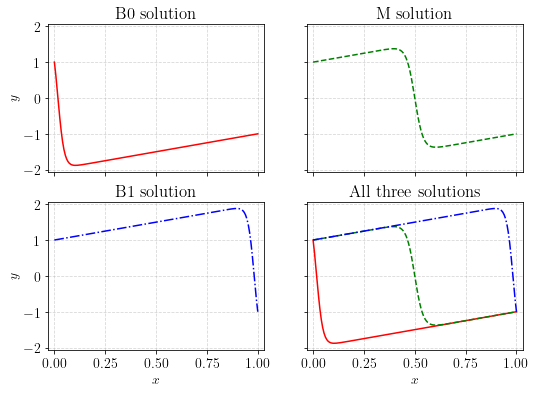

In [28]:
col_left, col_mid, col_right  = 'r', 'g', 'b'

fig, ax = plt.subplots(nrows=2, ncols=2,
                       sharex=True, sharey=True,
                       figsize=(8.5,6))

ax[0,0].plot(x_samples, y_B0, color=col_left,  linestyle='solid')
ax[0,1].plot(x_samples, y_M,  color=col_mid,   linestyle='dashed')
ax[1,0].plot(x_samples, y_B1, color=col_right, linestyle='dashdot')

ax[1,1].plot(x_samples, y_B0, color=col_left,  linestyle='solid')
ax[1,1].plot(x_samples, y_M,  color=col_mid,   linestyle='dashed')
ax[1,1].plot(x_samples, y_B1, color=col_right, linestyle='dashdot')

ax[1,0].set_xlabel('$x$')
ax[1,1].set_xlabel('$x$')

ax[0,0].set_ylabel('$y$')
ax[1,0].set_ylabel('$y$')

for i in np.arange(2):
    for j in np.arange(2):
        ax[i,j].set_xlim((-0.03,1.03))
        ax[i,j].grid(linestyle='dashed', alpha=0.5)

ax[0,0].set_title(f'B0 solution')
ax[0,1].set_title(f'M solution')
ax[1,0].set_title(f'B1 solution')
ax[1,1].set_title(f'All three solutions')

plt.show()

# Asymptotic solutions

We can check that the difference between our asymptotic solutions and high-quality numerical solutions have the correct convergence properties.  But first, we'll need to code up the asymptotic solutions. 

In [29]:
atan_half = log(3)/2

# Allow mpmath functions to act on numpy arrays
expv = np.vectorize(exp)
logv = np.vectorize(log)
log1pv = np.vectorize(log1p)
sinhv = np.vectorize(sinh)
coshv = np.vectorize(cosh)
tanhv = np.vectorize(tanh)
polylogv = np.vectorize(polylog)

def asymp_sol_B0_c0(eps, x):
    return x - 2 * tanhv(x / eps - atan_half)

def asymp_sol_B1_c0(eps, x):
    return -asymp_sol_B0_c0(eps, 1-x)

def asymp_sol_M_c0(eps, x):
    return x - 1/2 - 3/2 * tanhv(3/4 * (x - 1/2) / eps)

def Li2(z):
    return polylogv(2,z)

def asymp_sol_M_c1(eps, x):
    X = (x-1/2)/eps
    sinh_ = sinhv(3*X/2)
    cosh_ = coshv(3*X/4)
    log2cosh = logv(2*cosh_)
    exp_ = expv(-3*X/2)
    li2 = Li2(-exp_)
    
    return -3/2*tanhv(3*X/4) + \
        (eps/(72*cosh_*cosh_)) * (4*pi*pi + 48*li2 + 9*X*(8 + 3*X)
                                  + 48*sinh_*log2cosh)

def asymp_sol_B0_c1(eps, x):
    c1 = 1 + log(12)
    c2 = 1/8 * (-4*Li2(-3) + np.square(log(3)) + 4/3 * log(6912))

    X = x/eps
    Xbar = X - atan_half

    cosh_ = coshv(Xbar)
    logcosh = logv(cosh_)
    exp_ = expv(-2*Xbar)
    
    return -2*tanhv(Xbar) + \
           1/4*eps/(cosh_*cosh_) * (4*c2 + 2*Xbar*(Xbar + 1 + c1 - log(4)) + \
                                    2 * Li2(-exp_) + (-1 + c1 + 2 * logcosh) * sinhv(2*Xbar))

def asymp_sol_B1_c1(eps, x):
    return -asymp_sol_B0_c1(eps, 1-x)

## Interactive plot of asymptotic solutions

Let's examine these to make sure they look right

In [30]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [31]:
def plot_c1s(eps, num=100):
    x = np.linspace(0.,1., num=num)

    plt.plot(x, asymp_sol_B0_c1(eps, x), color=col_left,  linestyle='solid')
    plt.plot(x, asymp_sol_M_c1(eps, x),  color=col_mid,   linestyle='dashed')
    plt.plot(x, asymp_sol_B1_c1(eps, x), color=col_right, linestyle='dashdot')

    plt.show()

In [33]:
interact(plot_c1s, eps=(.006, .2, .005), num=fixed(150));

interactive(children=(FloatSlider(value=0.101, description='eps', max=0.2, min=0.006, step=0.005), Output()), …

## Convergence: Differences between numerical and asymptotic solutions

Find the right initial conditions for a range of $\epsilon$ values.  Just do this for B0 and M, since we can get B1 from B0.  This takes about 3 minutes on my laptop.

In [40]:
%%time

mp.dps=25

eps_for_conv_plot = np.array([.16, .08, .04, .02, .01])

y_B0_sols = {}
y_B1_sols = {}
y_M_sols = {}

for eps in eps_for_conv_plot:
    y_prime_0 = y_prime_B0_num(eps)
    y_B0_sols[eps] = odefun(make_odesys(eps), 0, [1, y_prime_0])

    y_prime_0 = y_prime_M_num(eps)
    y_M_sols[eps] = odefun(make_odesys(eps), 0, [1, y_prime_0])

CPU times: user 51.5 s, sys: 168 ms, total: 51.6 s
Wall time: 51.8 s


Now make a plot!

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


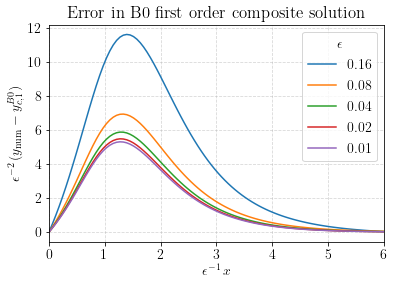

In [41]:
for eps in eps_for_conv_plot:
    sol = y_B0_sols[eps]
    x_to_plot = np.linspace(0, 6*eps, num=100)
    y_to_plot_num = np.array([sol(x)[0] for x in x_to_plot])
    y_to_plot_an  = asymp_sol_B0_c1(eps, x_to_plot)
    plt.plot(x_to_plot/eps,
             (y_to_plot_num - y_to_plot_an)/eps/eps,
             label=str(eps))

plt.xlabel(r'$\epsilon^{-1} \, x$')
plt.ylabel(r'$\epsilon^{-2} \, (y_{\mathrm{num}} - y^{B0}_{c,1})$')
plt.xlim((0,6))
plt.title('Error in B0 first order composite solution')

plt.legend(title=r'$\epsilon$')

plt.grid(linestyle='dashed', alpha=0.5)

plt.show()

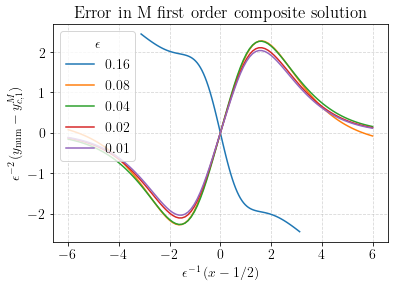

In [42]:
for eps in eps_for_conv_plot:
    sol = y_M_sols[eps]
    if eps > 1./12.:
        x_to_plot = np.linspace(0,1, num=100)
    else:
        x_to_plot = 0.5 + eps*np.linspace(-6,6, num=100)
    y_to_plot_num = np.array([sol(x)[0] for x in x_to_plot])
    y_to_plot_an  = asymp_sol_M_c1(eps, x_to_plot)
    plt.plot((x_to_plot-0.5)/eps,
             (y_to_plot_num - y_to_plot_an)/eps/eps,
             label=str(eps))

plt.xlabel(r'$\epsilon^{-1} \, (x-1/2)$')
plt.ylabel(r'$\epsilon^{-2} \, (y_{\mathrm{num}} - y^{M}_{c,1})$')
#plt.xlim((-6,6))
plt.title('Error in M first order composite solution')

plt.legend(title=r'$\epsilon$', loc='upper left')

plt.grid(linestyle='dashed', alpha=0.5)

plt.show()

# Asymptotics of initial slopes

The data for these plots take a while to calculate – they are precomputed by the script `precompute_slope_data.py`

In [31]:
from pathlib import Path
import pickle

In [32]:
with Path('B0_init_slope_data.pkl').open('rb') as pkl_file:
    (eps_B0, y_p_num_B0, y_p_asymp_B0) = pickle.load(pkl_file)
with Path('B1_init_slope_data.pkl').open('rb') as pkl_file:
    (eps_B1, one_minus_y_p_num_B1, one_minus_y_p_asymp_B1) = pickle.load(pkl_file)
with Path('M_init_slope_data.pkl').open('rb') as pkl_file:
    (eps_M, one_minus_y_p_num_M, one_minus_y_p_asymp_M) = pickle.load(pkl_file)

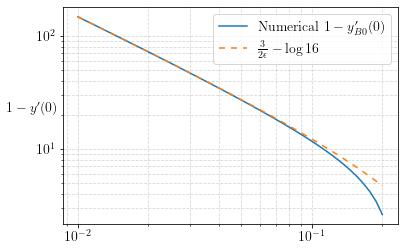

In [33]:
plt.loglog(eps_B0, 1-y_p_num_B0, label='Numerical $1-y_{B0}\'(0)$')
plt.loglog(eps_B0, 1-y_p_asymp_B0, dashes=[4,4],
           label='$\\frac{3}{2 \\epsilon} - \\log 16$')
plt.legend(loc='upper right')
plt.grid(linestyle='dashed', alpha=0.5, which='both')
ylab = plt.ylabel('$1-y\'(0)$')
ylab.set_rotation(0)

plt.show()

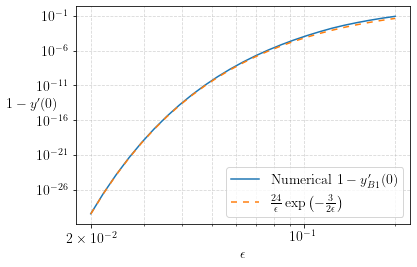

In [34]:
plt.loglog(eps_B1, one_minus_y_p_num_B1, label='Numerical $1-y_{B1}\'(0)$')
plt.loglog(eps_B1, one_minus_y_p_asymp_B1, dashes=[4,4],
           label=r'$\frac{24}{\epsilon} \exp \left(-\frac{3}{2\epsilon}\right)$')
plt.legend(loc='lower right')
plt.grid(linestyle='dashed', alpha=0.5, which='both')
plt.xlabel('$\\epsilon$')
ylab = plt.ylabel('$1-y\'(0)$')
ylab.set_rotation(0)
old_y_pos = ylab.get_position()
ylab.set_position((old_y_pos[0], old_y_pos[1] + .02))
plt.xticks(ticks=[.02, .1], labels=['$2\\times 10^{-2}$', '$10^{-1}$'])

plt.show()

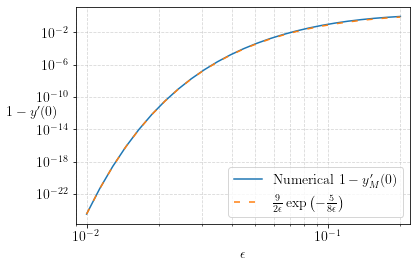

In [35]:
plt.loglog(eps_M, one_minus_y_p_num_M, label='Numerical $1-y_{M}\'(0)$')
plt.loglog(eps_M, one_minus_y_p_asymp_M, dashes=[4,6],
           label=r'$\frac{9}{2\epsilon} \exp \left(-\frac{5}{8\epsilon}\right)$')
plt.legend(loc='lower right')
plt.grid(linestyle='dashed', alpha=0.5, which='both')
plt.xlim((.009, .22))
plt.xlabel('$\\epsilon$')
ylab = plt.ylabel('$1-y\'(0)$')
ylab.set_rotation(0)
old_y_pos = ylab.get_position()
ylab.set_position((old_y_pos[0], old_y_pos[1] - .02))

plt.show()

# Zoom in to bifurcation

Every point on the bifurcation plot is totally independent, so we can parallelize

In [36]:
from itertools import product
from multiprocessing import Pool

In [37]:
mp.dps=20

epsc = eps_c_of_z_c(findroot(g_root, -3.9052637703))

Set up a $(\epsilon, y'(0))$ grid (here, $35 \times 35$) for evaluating $1+y(1)$

In [38]:
delta_eps_scale = 1.e-6
delta_eps_range = np.linspace(-1., 1., num=35)
y_prime_0_range = np.linspace(-.01, .01, num=35)

def pool_mappable_one_plus_y(arg):
    return 1+y_at_x_eq_1(epsc + delta_eps_scale*arg[0], arg[1])

In [39]:
%%time
pool = Pool()
vals = pool.map(pool_mappable_one_plus_y,
                product(delta_eps_range, y_prime_0_range))

vals = np.reshape(np.array(vals, dtype=np.float64),
                  (len(delta_eps_range), len(y_prime_0_range))).T

CPU times: user 67.3 ms, sys: 54.5 ms, total: 122 ms
Wall time: 31.9 s


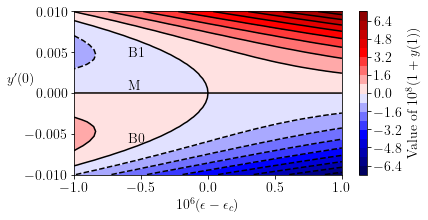

In [40]:
fig = plt.figure(figsize=(6,3))

eps_plot, y_prime_plot = np.meshgrid(delta_eps_range, y_prime_0_range)

levels=20

plt.contour(eps_plot, y_prime_plot, vals, levels, colors='k')
plt.contourf(eps_plot, y_prime_plot, 1.e8*vals, levels, cmap='seismic')
cbar = plt.colorbar()
cbar.set_label(r'Value of $10^{8}(1+y(1))$')

plt.annotate("B1", (-0.6, .0045))
plt.annotate("M",  (-0.6, 0.0005))
plt.annotate("B0", (-.6, -.006))

plt.xlabel(r'$10^{6} (\epsilon - \epsilon_c)$')

ylab = plt.ylabel('$y\'(0)$')
ylab.set_rotation(0)
old_y_pos = ylab.get_position()
ylab.set_position((old_y_pos[0], old_y_pos[1] + .04))

plt.show()